In [2]:
import sys
sys.path.append('../')
import hicap_analysis.wells as wo
from hicap_analysis.miwwat_approach import MiWWAT

import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Set some paths
shapefiles and a testing csv file are in the tests directory.

In [3]:
homepath = Path(os.getcwd())

# Make a wwat object

The wwat object needs a shapefile with the desired catchments
and one with the corresponding streamlines.  catch_idx and stream_idx
are optional and will be used to set the indices of the returned
geodataframes if provided.  

In [4]:
wwat = MiWWAT(catchment_shp='Revision11_Catchment_GW_MI.shp',
              streamline_shp='revision11_linework_gw_mi.shp', 
              catch_idx='ADJ_SEGMNT', 
              stream_idx='ADJ_SEGMNT')

C:\Users\hwreeves\AppData\Local\miniforge3\envs\hca\Lib\site-packages\pyogrio\raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


In [5]:
wwat.catchment_df.columns

Index(['BASIN', 'SUBBASIN', 'EST_DPH_BR', 'BDRK_FLAG', 'BDRK_T', 'MEDIAN_T',
       'EST_Kv_W', 'TYPE', 'geometry'],
      dtype='object')

In [6]:
wwat.streamline_df.columns

Index(['BASIN', 'SUBBASIN', 'EST_DPH_BR', 'BDRK_FLAG', 'BDRK_T', 'MEDIAN_T',
       'EST_Kv_W', 'TYPE', 'geometry'],
      dtype='object')

# make a well dataframe

The geoprocess will take a list of [lat, long] pairs, a geodataframe, 
or a dataframe with the lat, long of target wells.  In this test, I'm 
passing a dataframe and the processor makes a geodataframe and reprojects
to the same projection as the Geoprocess object.

In [7]:
well = [{'name': 'testwell0',
    'lat': 44.979953,
    'long': -84.625023,
    'rate': 70,
    'depth': 80},
   {'name': 'testwell1',
    'lat': 44.99,
    'long': -84.64,
    'rate': 70,
    'depth': 80}]  #gpm and ft

well_df=pd.DataFrame(well)

In [8]:
well_df.head()

,name,lat,long,rate,depth
0,testwell0,44.979953,-84.625023,70,80
1,testwell1,44.990000,-84.640000,70,80


# test reading from an excel file

In [9]:
well_df2 = pd.read_excel('miwwat_example_input.xlsx',
                         skiprows=1)
well_df2.rename(columns={'latitude':'lat', 
                         'longitude': 'long',
                         'pumping rate, gpm': 'rate',
                         'top of screen, ft': 'depth'},
               inplace=True)

In [10]:
well_df2.head()

,Test number,name,lat,long,rate,depth
0,1,testwell0,44.979953,-84.625023,70,80
1,2,testwell1,44.990000,-84.640000,70,80


In [11]:
well_df = well_df2.copy()

## pass the dataframe to the geoprocessor

The get_geometries() returns a WellGeometry objects.

In [12]:
well_list = wwat.get_geometries(well_df)
well_list

## WellGeometry objects

The attributes are:

- name
- geodataframe of catchment with the well (home_df)
- geodataframe of the neighboring catchments (neighbors_df)
- geodataframe of the streamlines for the catchments (streams_df)
- dataframe of the closest point on the stream for each catchment
  and apportionment for inverse-distance and inverse-distance-squared

In [13]:
# testwell0 should match the table from SIR
home = well_list[0].home_df.copy()
nearest = well_list[0].close_points_df.copy()

In [14]:
home.head()

,BASIN,SUBBASIN,EST_DPH_BR,BDRK_FLAG,BDRK_T,MEDIAN_T,EST_Kv_W,TYPE,geometry,Test number,lat,long,rate,depth
ADJ_SEGMNT,,,,,,,,,,,,,,
13925,Au Sable,N Br Au Sable River at Below Chubb Creek,814.230408,0.0,0.0,7819.0,288.937988,Warm stream,"POLYGON ((604618.893 500172.864, 604648.761 50...",1,44.979953,-84.625023,70,80


In [15]:
nearest

,distance,geometry,inv_distance,inv_dist2,apportionment,apport2
ADJ_SEGMNT,,,,,,
11,15745.034793,POINT (612500.596 490726.699),0.000064,4.033785e-09,0.149232,0.148351
77,47819.169791,POINT (601878.374 479831.264),0.000021,4.373166e-10,0.049136,0.016083
9741,27561.440624,POINT (607804.776 484555.517),0.000036,1.316425e-09,0.085252,0.048414
10950,37799.536913,POINT (604107.229 503702.844),0.000026,6.998856e-10,0.062161,0.025740
11967,14798.924406,POINT (610798.946 489227.73),0.000068,4.566040e-09,0.158772,0.167926
12039,19063.389627,POINT (607257.679 498674.488),0.000052,2.751692e-09,0.123255,0.101200
12515,17033.749897,POINT (612831.957 495381.071),0.000059,3.446509e-09,0.137942,0.126753
13925,10030.596491,POINT (606697.165 490309.153),0.000100,9.939087e-09,0.234249,0.365532


In [16]:
well_list[0].transmissivity

np.float64(7819.0)

In [17]:
well_list[0].streambed_cond

np.float64(3.6117248535125)

In [18]:
# need to call the hunt99 function
time = 5. * 365.25  # 5 years
# pumping is 70 gpm; 1 gpm = 0.0022280093 cfs
Q = well_df.loc[0,'rate'] * 0.0022280093 * 3600 * 24  # rate in CFD for function.
T = well_list[0].transmissivity
S = well_list[0].storativity
streambed = well_list[0].streambed_cond

In [19]:
# hunt99 returns CFS need to convert to GPM for table
nearest['analytical_removal'] = nearest['distance'].apply(lambda dist: wo._hunt99(T, S, time, dist, Q, streambed)* 448.83116885)
nearest['valley_seg_removal'] = nearest['apportionment'] * nearest['analytical_removal']
nearest['percent'] = nearest['apportionment'] * 100.

# Hunt 1999 (and 2003) depletion equations are available as python functions

depl = _hunt99(T, S, time, dist, Q, streambed)

# Note you can easily plot the geodataframes or write as shapefile

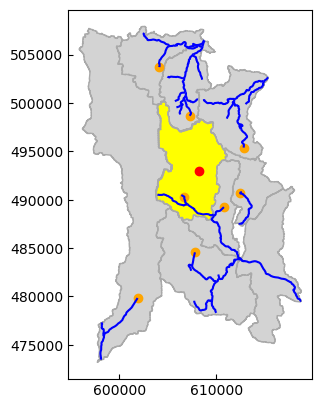

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
well_list[0].neighbors_df.plot(ax=ax, color='lightgray', edgecolor='darkgray')
home.plot(ax=ax, color='yellow', edgecolor='darkgray')
well_list[0].well_df.plot(ax=ax, color='red')
well_list[0].streams_df.plot(ax=ax, color='blue')
nearest.plot(ax=ax, color='orange')
ax.tick_params(direction='in')

In [21]:
nearest.to_file(homepath / 'output' / 'nearest.shp')

C:\Users\hwreeves\AppData\Local\Temp\2\ipykernel_13304\2382746851.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nearest.to_file(homepath / 'output' / 'nearest.shp')
C:\Users\hwreeves\AppData\Local\miniforge3\envs\hca\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
C:\Users\hwreeves\AppData\Local\miniforge3\envs\hca\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'inv_distance' to 'inv_distan'
  ogr_write(
C:\Users\hwreeves\AppData\Local\miniforge3\envs\hca\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'apportionment' to 'apportionm'
  ogr_write(
C:\Users\hwreeves\AppData\Local\miniforge3\envs\hca\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'analytical_remova

In [22]:
nearest

,distance,geometry,inv_distance,inv_dist2,apportionment,apport2,analytical_removal,valley_seg_removal,percent
ADJ_SEGMNT,,,,,,,,,
11,15745.034793,POINT (612500.596 490726.699),0.000064,4.033785e-09,0.149232,0.148351,49.573586,7.397962,14.923194
77,47819.169791,POINT (601878.374 479831.264),0.000021,4.373166e-10,0.049136,0.016083,23.150745,1.137544,4.913640
9741,27561.440624,POINT (607804.776 484555.517),0.000036,1.316425e-09,0.085252,0.048414,38.642352,3.294330,8.525179
10950,37799.536913,POINT (604107.229 503702.844),0.000026,6.998856e-10,0.062161,0.025740,30.242303,1.879896,6.216113
11967,14798.924406,POINT (610798.946 489227.73),0.000068,4.566040e-09,0.158772,0.167926,50.495621,8.017315,15.877249
12039,19063.389627,POINT (607257.679 498674.488),0.000052,2.751692e-09,0.123255,0.101200,46.389207,5.717711,12.325521
12515,17033.749897,POINT (612831.957 495381.071),0.000059,3.446509e-09,0.137942,0.126753,48.327468,6.666366,13.794156
13925,10030.596491,POINT (606697.165 490309.153),0.000100,9.939087e-09,0.234249,0.365532,55.225855,12.936628,23.424948


In [23]:
well_list

In [24]:
well_list[0].name

'testwell0'

In [25]:
well_list[0].home_df

,BASIN,SUBBASIN,EST_DPH_BR,BDRK_FLAG,BDRK_T,MEDIAN_T,EST_Kv_W,TYPE,geometry,Test number,lat,long,rate,depth
ADJ_SEGMNT,,,,,,,,,,,,,,
13925,Au Sable,N Br Au Sable River at Below Chubb Creek,814.230408,0.0,0.0,7819.0,288.937988,Warm stream,"POLYGON ((604618.893 500172.864, 604648.761 50...",1,44.979953,-84.625023,70,80


In [26]:
well_list[0].summarize()

Name = testwell0
Aquifer type = drift
Transmissivity = 7819.0
Storativity = 0.01
Streambed conductance = 3.6117248535125
Home Catchment
|   ADJ_SEGMNT | BASIN    |   lat |    long |   rate |   depth |
|-------------:|:---------|------:|--------:|-------:|--------:|
|        13925 | Au Sable | 44.98 | -84.625 |     70 |      80 |

Neighboring Catchments
|   ADJ_SEGMNT_left | BASIN_left   | TYPE_left        |
|------------------:|:-------------|:-----------------|
|                11 | Au Sable     | Warm stream      |
|                77 | Au Sable     | Cold stream      |
|              9741 | Au Sable     | Cool stream      |
|             10950 | Cheboygan    | Cold stream      |
|             11967 | Au Sable     | Warm small river |
|             12039 | Cheboygan    | Cold stream      |
|             12515 | Cheboygan    | Cold stream      |
|             13925 | Au Sable     | Warm stream      |

Streams
|   ADJ_SEGMNT_left | BASIN     | SUBBASIN                                 |